In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from scipy.stats import zscore

### Data Loading pipeline(Subject 1)

In [59]:
#load data directory 
dir_data = 'data'
dir_resp = os.path.join(dir_data, 'respiration')
dir_ebit = os.path.join(dir_data, 'emotibit')
resp_path = os.path.join(dir_resp, 'digital_twin_vernier_sub1.csv')
emoti_path = os.path.join(dir_ebit, 'digital_twin_emotibit_sub1.csv')
resp_df = pd.read_csv(resp_path)
emoti_df = pd.read_csv(emoti_path)

# parsing the timestamp
resp_df['timestamp'] = pd.to_datetime(resp_df['timestamp'])
emoti_df['timestamp'] = pd.to_datetime(emoti_df['timestamp'])

# calucalted the elapsed time
resp_df['elapsed_time'] = (resp_df['timestamp'] - resp_df['timestamp'].iloc[0]).dt.total_seconds()
emoti_df['elapsed_time'] = (emoti_df['timestamp'] - emoti_df['timestamp'].iloc[0]).dt.total_seconds()

# function for calculating the rmssd
def compute_rmssd(bi_values):
    diff = np.diff(bi_values)
    return np.sqrt(np.mean(diff**2)) if len(diff) > 1 else np.nan

# function for calculating the zscore
def zscore(series):
    return (series - series.mean()) / series.std()

# calculate hrv
bi_series = emoti_df.dropna(subset=["BI"])[["elapsed_time", "BI"]].reset_index(drop=True)
window_size = 5
hrv_values = []
hrv_timestamps = []

for i in range(window_size, len(bi_series)):
    window = bi_series["BI"].iloc[i-window_size:i].values
    rmssd = compute_rmssd(window)
    hrv_values.append(rmssd)
    hrv_timestamps.append(bi_series["elapsed_time"].iloc[i])

hrv_df = pd.DataFrame({
    "elapsed_time": hrv_timestamps,
    "RMSSD": hrv_values
})

# zscore biometrics 
emoti_df["EDA_z"] = zscore(emoti_df["EDA"])
emoti_df["HR_z"] = zscore(emoti_df["HR"])
resp_df["force_z"] = zscore(resp_df["force"])
resp_df["RR_z"] = zscore(resp_df["RR"])
hrv_df["RMSSD_z"] = zscore(hrv_df["RMSSD"])


Two devices started at different times, so we need to align the timestamps. We will only include the overlapping timestamps of the two devices. 

In [60]:
#common time grid
start = max(resp_df['elapsed_time'].min(), emoti_df['elapsed_time'].min(), hrv_df['elapsed_time'].min())
end = min(resp_df['elapsed_time'].max(), emoti_df['elapsed_time'].max(), hrv_df['elapsed_time'].max())
common_time = np.arange(start, end, 1.0)  # At one second resolution

#Interpolation helper
def interpolate_signal(df, time_col, value_col, common_time):
    df = df.dropna(subset=[time_col, value_col])
    return np.interp(common_time, df[time_col], df[value_col])

#Interpolate z-scored signals to common time
eda_z_interp = interpolate_signal(emoti_df, 'elapsed_time', 'EDA_z', common_time)
hr_z_interp = interpolate_signal(emoti_df, 'elapsed_time', 'HR_z', common_time)
rr_z_interp = interpolate_signal(resp_df, 'elapsed_time', 'RR_z', common_time)
force_z_interp = interpolate_signal(resp_df, 'elapsed_time', 'force_z', common_time)
hrv_z_interp = interpolate_signal(hrv_df, 'elapsed_time', 'RMSSD_z', common_time)

# Combine into an aligned DataFrame
aligned_df = pd.DataFrame({
    'elapsed_time': common_time,
    'EDA_z': eda_z_interp,
    'HR_z': hr_z_interp,
    'RR_z': rr_z_interp,
    'force_z': force_z_interp,
    'HRV_RMSSD_z': hrv_z_interp
})

In [61]:
aligned_df

,elapsed_time,EDA_z,HR_z,RR_z,force_z,HRV_RMSSD_z
0,2.960801,-2.484001,0.509280,-1.243099,-1.590434,-1.187258
1,3.960801,-2.502442,0.473262,-1.374811,-1.350550,-1.177748
2,4.960801,-2.520191,0.435064,-1.506523,-1.498415,-1.172181
3,5.960801,-2.538738,0.425972,-1.638235,-1.258350,-1.143527
4,6.960801,-2.545270,0.434617,-1.769946,-1.446104,-1.143527
...,...,...,...,...,...,...
4737,4739.960801,-0.251043,-0.125506,0.624416,-1.097470,0.055877
4738,4740.960801,-0.221583,-0.267973,0.618146,0.078520,0.070453
4739,4741.960801,0.049025,0.218011,0.611875,-1.159060,7.831488
4740,4742.960801,0.487663,0.313537,0.605604,-1.130268,8.107089


In [62]:
aligned_df.to_csv('~/Desktop/aligned.csv', index=False)

In [63]:
w_hrv = 37.5 / 100  
w_eda = 31.25 / 100 
w_hr = 18.75 / 100  
w_rr = 12.5 / 100   

# 

In [64]:
aligned_df['calibrated_stress_index'] = (
    -w_hrv * aligned_df['HRV_RMSSD_z'] +
     w_eda * aligned_df['EDA_z'] +
     w_hr  * aligned_df['HR_z'] +
     w_rr  * aligned_df['RR_z']
)

In [65]:
aligned_df

,elapsed_time,EDA_z,HR_z,RR_z,force_z,HRV_RMSSD_z,calibrated_stress_index
0,2.960801,-2.484001,0.509280,-1.243099,-1.590434,-1.187258,-0.390926
1,3.960801,-2.502442,0.473262,-1.374811,-1.350550,-1.177748,-0.423472
2,4.960801,-2.520191,0.435064,-1.506523,-1.498415,-1.172181,-0.454733
3,5.960801,-2.538738,0.425972,-1.638235,-1.258350,-1.143527,-0.489443
4,6.960801,-2.545270,0.434617,-1.769946,-1.446104,-1.143527,-0.506327
...,...,...,...,...,...,...,...
4737,4739.960801,-0.251043,-0.125506,0.624416,-1.097470,0.055877,-0.044885
4738,4740.960801,-0.221583,-0.267973,0.618146,0.078520,0.070453,-0.068641
4739,4741.960801,0.049025,0.218011,0.611875,-1.159060,7.831488,-2.804126
4740,4742.960801,0.487663,0.313537,0.605604,-1.130268,8.107089,-2.753275


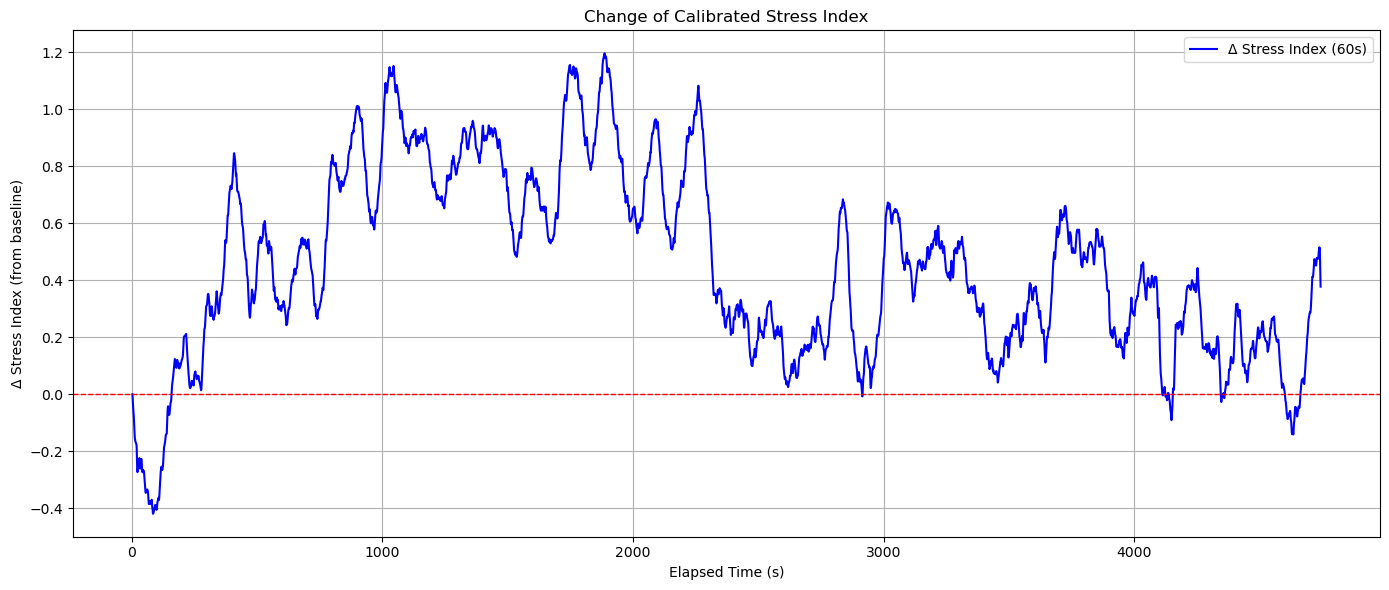

In [72]:
# Step 1: Calculate change from baseline
aligned_df['delta_calibrated_stress'] = aligned_df['calibrated_stress_index'] - aligned_df['calibrated_stress_index'].iloc[0]

# Step 2: Smooth using a rolling average (e.g., 60s window)
window_sec = 60
aligned_df['delta_calibrated_stress_smooth'] = aligned_df['delta_calibrated_stress'].rolling(window=window_sec, min_periods=1).mean()

# Step 3: Plot the smoothed delta stress index
plt.figure(figsize=(14, 6))
plt.plot(
    aligned_df['elapsed_time'],
    aligned_df['delta_calibrated_stress_smooth'],
    label='Δ Stress Index (60s)',
    color='blue'
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Change of Calibrated Stress Index')
plt.xlabel('Elapsed Time (s)')
plt.ylabel('Δ Stress Index (from baseline)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
